# Auto-Interpretability Analysis

### Sanity Checks 

In [14]:
from safetensors import safe_open
from transformers import AutoTokenizer

In [53]:
size = "160m"

base_latents = safe_open(f"latents/pythia_{size}/baseline/layers.6/.gpt_neox.layers.6/0_12287.safetensors", framework="pytorch")

cluster_latents = safe_open(f"latents/pythia_{size}/cluster/k1-c0/.gpt_neox.layers.6/0_12287.safetensors", framework="pytorch")

latents = cluster_latents
tokenizer = AutoTokenizer.from_pretrained(f"EleutherAI/pythia-{size}")

In [54]:
latents.get_tensor("activations").shape, latents.get_tensor("locations").shape, latents.get_tensor("tokens").shape

(torch.Size([6271616]), torch.Size([6271616, 3]), torch.Size([39072, 256]))

In [55]:
latents.get_tensor("locations")

tensor([[    0,     1,    35],
        [    0,     2,    54],
        [    0,     3,    28],
        ...,
        [39071,   248,    30],
        [39071,   251,    62],
        [39071,   255,    56]])

### Setup

In [1]:
import os
import json
import numpy as np
import pandas as pd

from group_sae.utils import load_training_clusters, load_cluster_map, MODEL_MAP

FUZZ_DIR = "results/fuzzing"
DETECT_DIR = "results/detection"

Triton not installed, using eager implementation of SAE decoder.


In [2]:
def extract_latent(file_name: str):
    file_name = file_name.split(".txt")[0]
    layer, latent = file_name.split("_latent")
    layer = layer.split(".")[-1]
    return int(latent), int(layer)


def load_cluster_results(size, cluster_id, what="fuzzing", warnings=True):
    cluster_map = load_training_clusters(size)
    layers = cluster_map[cluster_id]

    if what == "fuzzing":
        path = os.path.join(FUZZ_DIR, f"pythia-{size.lower()}/{cluster_id}")
    elif what == "detection":
        path = os.path.join(DETECT_DIR, f"pythia-{size.lower()}/{cluster_id}")
    else:
        raise ValueError("what must be either 'fuzzing' or 'detection'")

    def extract_latent(file_name: str):
        file_name = file_name.split(".txt")[0]
        layer, latent = file_name.split("_latent")
        layer = layer.split(".")[-1]
        return int(latent), int(layer)

    def spot_nans(x):
        if any([i is None for i in x]) and warnings:
            print(f"Found None in {file_name}")
        return [i for i in x if i is not None]

    results = {"latent": [], "layer": [], "correct": []}

    for file_name in os.listdir(path):
        latent, layer = extract_latent(file_name)

        if str(layer) in layers:
            with open(os.path.join(path, file_name), "r") as f:
                data = json.load(f)

            corrects = spot_nans([prompt["correct"] for prompt in data])

            results["latent"].append(latent)
            results["layer"].append(layer)
            results["correct"].append(np.mean(corrects) * 100)

    results = pd.DataFrame(results)
    results["cluster_id"] = cluster_id
    results["size"] = size
    return results


def load_baseline_results(size, what="fuzzing", warnings=True):

    if what == "fuzzing":
        path = os.path.join(FUZZ_DIR, f"pythia-{size.lower()}/baseline")
    elif what == "detection":
        path = os.path.join(DETECT_DIR, f"pythia-{size.lower()}/baseline")
    else:
        raise ValueError("what must be either 'fuzzing' or 'detection'")

    def spot_nans(x):
        if any([i is None for i in x]) and warnings:
            print(f"Found None in {file_name}")
        return [i for i in x if i is not None]

    results = {"latent": [], "layer": [], "correct": []}

    for file_name in os.listdir(path):
        latent, layer = extract_latent(file_name)

        with open(os.path.join(path, file_name), "r") as f:
            data = json.load(f)

        corrects = spot_nans([prompt["correct"] for prompt in data])

        results["latent"].append(latent)
        results["layer"].append(layer)
        results["correct"].append(np.mean(corrects) * 100)

    results = pd.DataFrame(results)
    results["cluster_id"] = results["layer"].apply(lambda x: f"layers.{x}")
    results["size"] = size
    return results


def load_results(size, what="fuzzing", warnings=True):
    training_clusters = load_training_clusters(size)
    all_results = [
        load_cluster_results(size, cluster_id, what, warnings)
        for cluster_id in training_clusters.keys()
    ]
    all_results.append(load_baseline_results(size, what, warnings))
    return pd.concat(all_results)


def load_and_map_results(size, what="fuzzing", warnings=True):
    results = load_results(size, what, warnings)
    summ_results = results.groupby(["size", "cluster_id", "layer"])["correct"].mean().reset_index()

    cluster_map = load_cluster_map(size)
    n_layers = MODEL_MAP[f"pythia-{size.lower()}"]["n_layers"]

    empty_results = pd.DataFrame(
        {
            "G": np.arange(1, n_layers).repeat(n_layers - 1),
            "cluster_id": [item for sublist in cluster_map.values() for item in sublist]
            + [f"layers.{i}" for i in range(n_layers - 1)],
            "layer": np.tile(np.arange(n_layers - 1), n_layers - 1),
        }
    )
    empty_results["G"] = empty_results["G"].astype(str).apply(lambda x: "B" if x == str(n_layers - 1) else x)
    return pd.merge(empty_results, summ_results, on=["cluster_id", "layer"], how="left")

In [27]:
fuzz_df = pd.concat([
    load_and_map_results("160m", "fuzzing", warnings=False),
    load_and_map_results("410m", "fuzzing", warnings=False),
    load_and_map_results("1b", "fuzzing", warnings=False),
])

detect_df = pd.concat([
    load_and_map_results("160m", "detection", warnings=False),
    load_and_map_results("410m", "detection", warnings=False),
    load_and_map_results("1b", "detection", warnings=False),
])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from group_sae.utils import palette

suptitle_fontsize = 16
title_fontsize = 16
label_fontsize = 14
tick_fontsize = 10
annot_fontsize = 7

label_pad = 8
title_pad = 10

#palette = ["#F7C485", "#F4B279", "#EB7E80"]

def plot_fuzz_detect(size, save=False):
    # Create a figure with 2 subplots in a 1x2 layout
    fig, ax = plt.subplots(1, 2, figsize=(12, 4.5), dpi=150, layout="tight")

    # Get the cluster IDs for the specific k value

    n_layers = MODEL_MAP[f"pythia-{size.lower()}"]["n_layers"]
    fuzz_subdf = fuzz_df[fuzz_df["size"] == size]
    detect_subdf = detect_df[detect_df["size"] == size]

    # Generate the expanded palette by interpolating between the base colors
    expanded_palette = sns.blend_palette(palette, n_colors=n_layers - 2)
    expanded_palette.append("#ced4da")

    for i, (eval_df, what) in enumerate(zip([fuzz_subdf, detect_subdf], ["fuzzing", "detection"])):
        sns.barplot(
            data=eval_df,
            x="G",
            hue="G",
            y="correct",
            ax=ax[i],
            zorder=2,
            palette=expanded_palette,
            legend=False,
        )

        #baseline_value = eval_df.loc[eval_df["G"] == "B", "correct"].iloc[0]
        #for j, patch in enumerate(ax[i].patches):
            # current_label = eval_df.loc[j, "G"]
            # current_value = patch.get_height()
            # # Calculate the delta percentage with respect to the baseline.
            # delta_pct = (current_value - baseline_value) / baseline_value * 100

            # For the baseline bar you may simply show "0%"; for others, include a '+' sign if nonnegative.
            # text = "0%" if current_label == "B" else f"{'+' if delta_pct >= 0 else ''}{delta_pct:.1f}%"

            # Position the text: center of the bar horizontally, and just above the bar.
            # x = patch.get_x() + patch.get_width() / 2.
            # y = current_value # add something
            # ax[i].text(x, y, text, ha="center", va="bottom", fontsize=annot_fontsize)

        ylims = (50, 80)
        ax[i].set_title(what.capitalize(), pad=title_pad, fontsize=label_fontsize)
        ax[i].set_ylim(ylims)
        ax[i].set_xlabel("G", labelpad=label_pad, fontsize=label_fontsize)
        ax[i].set_ylabel("")
        ax[i].tick_params(axis="x", labelsize=tick_fontsize)
        ax[i].tick_params(axis="y", labelsize=tick_fontsize)
        ax[i].grid(color="#adb5bd", linestyle="--", linewidth=0.5)

        # For the right plot, add a plus sign and percent symbol to the y-tick labels
        ax[i].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.0f}%"))

    plt.suptitle(f"Pythia {size}", fontsize=suptitle_fontsize)
    plt.subplots_adjust(hspace=0.4)

    if save:
        plt.savefig(f"imgs/avg_recon_{size}.svg", dpi=300, bbox_inches="tight")

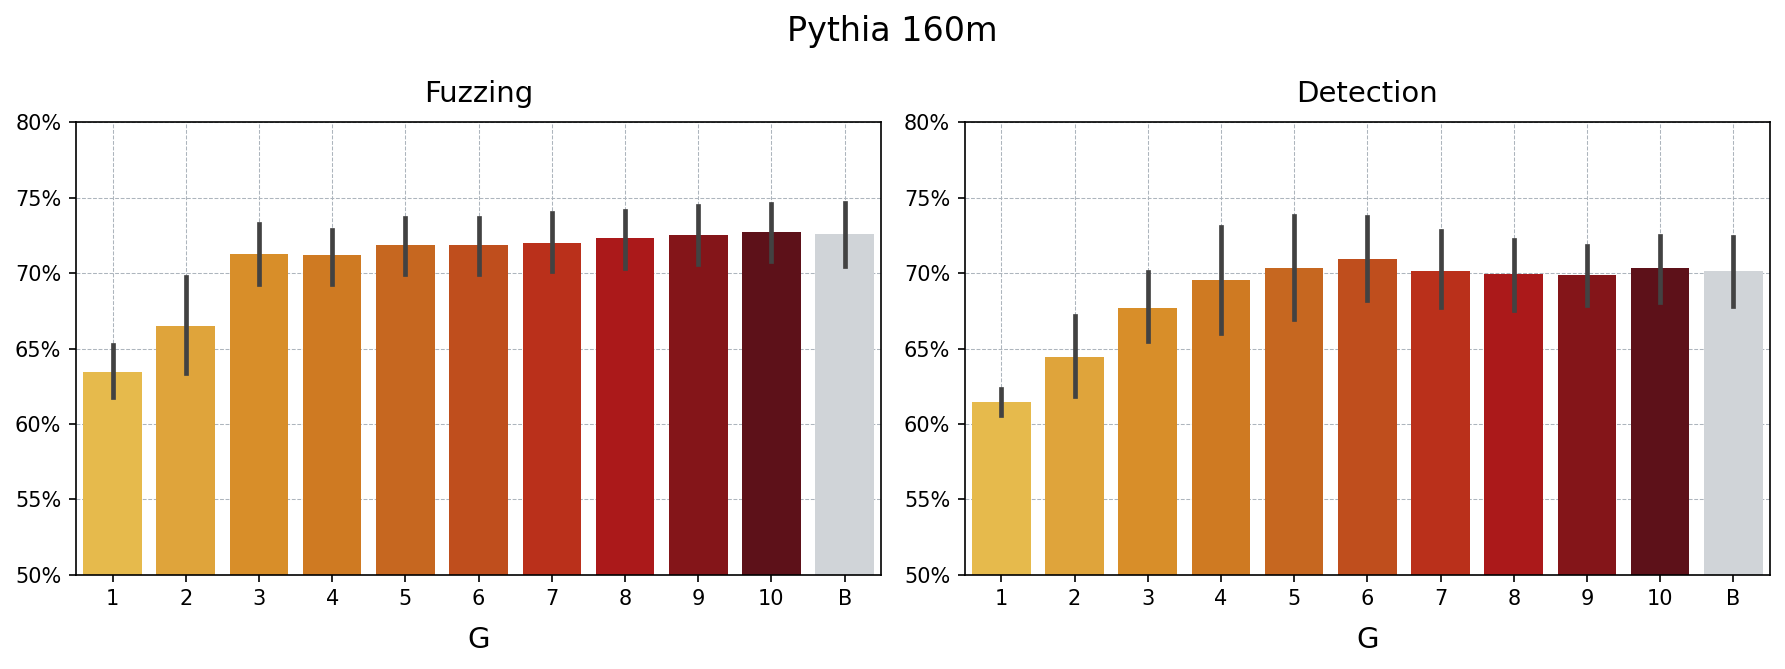

In [6]:
plot_fuzz_detect("160m", save=True)

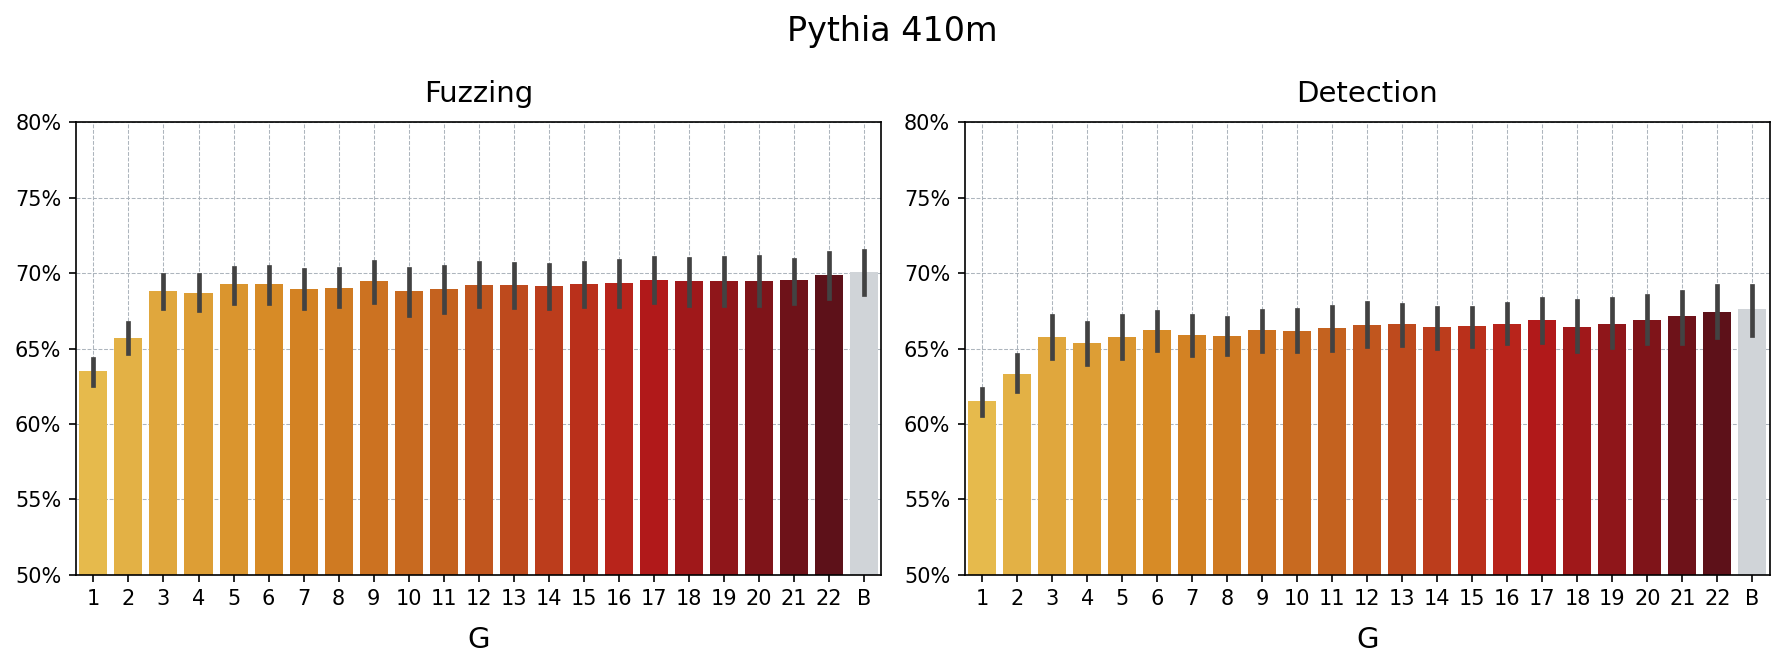

In [7]:
plot_fuzz_detect("410m", save=True)

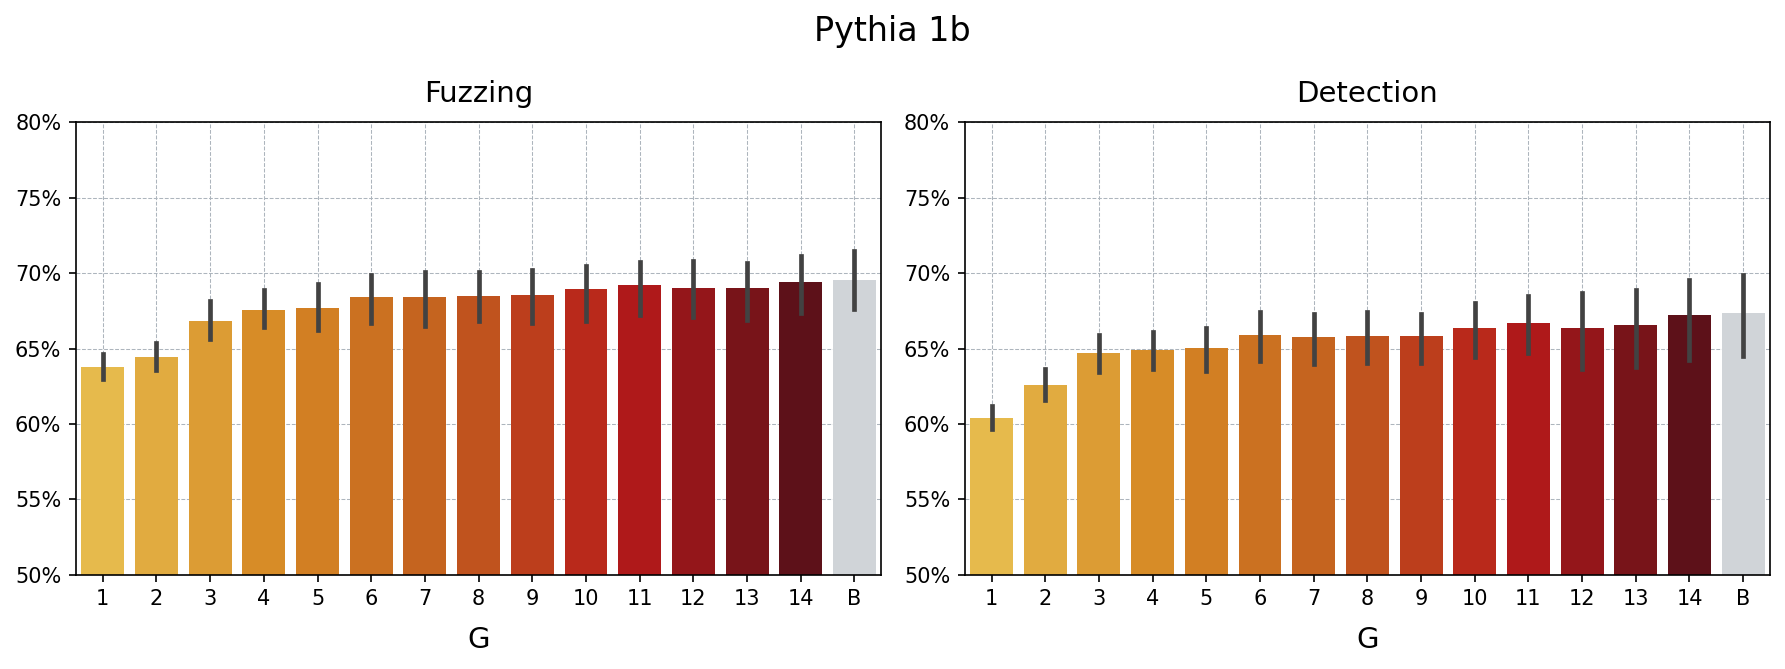

In [8]:
plot_fuzz_detect("1b", save=True)

In [121]:
from group_sae.utils import load_amds

amds_160m = load_amds("160m")
amds_160m["size"] = "160m"

amds_410m = load_amds("410m")
amds_410m["size"] = "410m"

amds_1b = load_amds("1b")
amds_1b["size"] = "1b"

amds = pd.concat([amds_160m, amds_410m, amds_1b]).drop(columns=["C"])
amds["G"] = amds["G"].astype(str)


fuzz_df_amd = fuzz_df.copy()
base_160m_mask = (fuzz_df_amd["size"] == "160m") & (fuzz_df_amd["G"] == "B")
base_410m_mask = (fuzz_df_amd["size"] == "410m") & (fuzz_df_amd["G"] == "B")
base_1b_mask = (fuzz_df_amd["size"] == "1b") & (fuzz_df_amd["G"] == "B")

fuzz_df_amd.loc[base_160m_mask, "G"] = 11
fuzz_df_amd.loc[base_410m_mask, "G"] = 23
fuzz_df_amd.loc[base_1b_mask, "G"] = 15

fuzz_df_amd = pd.merge(fuzz_df_amd, amds, on=["size", "G"], how="left")
fuzz_df_amd["AMD"].fillna(0, inplace=True)


detect_df_amd = detect_df.copy()
base_160m_mask = (detect_df_amd["size"] == "160m") & (detect_df_amd["G"] == "B")
base_410m_mask = (detect_df_amd["size"] == "410m") & (detect_df_amd["G"] == "B")
base_1b_mask = (detect_df_amd["size"] == "1b") & (detect_df_amd["G"] == "B")

detect_df_amd.loc[base_160m_mask, "G"] = 11
detect_df_amd.loc[base_410m_mask, "G"] = 23
detect_df_amd.loc[base_1b_mask, "G"] = 15

detect_df_amd = pd.merge(detect_df_amd, amds, on=["size", "G"], how="left")
detect_df_amd["AMD"].fillna(0, inplace=True)

/var/folders/_v/2m0mxgk14csgpyktpk5mjh_40000gn/T/ipykernel_29618/1654404288.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  fuzz_df_amd["AMD"].fillna(0, inplace=True)
/var/folders/_v/2m0mxgk14csgpyktpk5mjh_40000gn/T/ipykernel_29618/1654404288.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

In [139]:
suptitle_fontsize = 16
title_fontsize = 16
label_fontsize = 14
tick_fontsize = 12
annot_fontsize = 6.5

label_pad = 8
title_pad = 10

def get_inf_sup(df: pd.DataFrame, is_sorted: bool = False):
    df_sorted = df
    if not is_sorted:
        df_sorted = df.sort_values("AMD", ascending=False)
    end = (df_sorted["AMD"] >= 0.2).argmin()
    start = max(0, end - 1)
    return (start, end)

def plot_vs_amd(df, ax):
    plot_df = df[df["size"] == "160m"]
    sns.lineplot(plot_df, x="AMD", y="correct", color=palette[0], ax=ax, errorbar=("sd", 0.5))
    avg_plot = plot_df.groupby("G")[["AMD", "correct"]].mean()
    avg_plot.sort_values("AMD", inplace=True, ascending=False)
    ids = get_inf_sup(avg_plot)
    sns.scatterplot(avg_plot, x="AMD", y="correct", color=palette[0], ax=ax, legend=False)
    last_row = avg_plot.iloc[-1]
    ax.scatter(
        last_row["AMD"],
        last_row["correct"],
        marker="*",
        s=120,
        color=palette[0],
        edgecolor="black",
        zorder=10,
    )
    square_x = avg_plot.iloc[ids[-1]]["AMD"]
    square_y = avg_plot.iloc[ids[-1]]["correct"]
    ax.scatter(
        square_x,
        square_y,
        marker="s",
        s=30,
        color=palette[0],
        edgecolor="black",
        zorder=10,
    )
    
    plot_df = df[df["size"] == "410m"]
    sns.lineplot(plot_df, x="AMD", y="correct", color=palette[2], ax=ax, errorbar=("sd", 0.5))
    avg_plot = plot_df.groupby("G")[["AMD", "correct"]].mean()
    avg_plot.sort_values("AMD", inplace=True, ascending=False)
    ids = get_inf_sup(avg_plot)
    sns.scatterplot(avg_plot, x="AMD", y="correct", color=palette[2], ax=ax, legend=False)
    last_row = avg_plot.iloc[-1]
    ax.scatter(
        last_row["AMD"],
        last_row["correct"],
        marker="*",
        s=120,
        color=palette[2],
        edgecolor="black",
        zorder=10,
    )
    square_x = avg_plot.iloc[ids[-1]]["AMD"]
    square_y = avg_plot.iloc[ids[-1]]["correct"]
    ax.scatter(
        square_x,
        square_y,
        marker="s",
        s=30,
        color=palette[2],
        edgecolor="black",
        zorder=10,
    )

    plot_df = df[df["size"] == "1b"]
    sns.lineplot(plot_df, x="AMD", y="correct", color=palette[3], ax=ax, errorbar=("sd", 0.5))
    avg_plot = plot_df.groupby("G")[["AMD", "correct"]].mean()
    avg_plot.sort_values("AMD", inplace=True, ascending=False)
    ids = get_inf_sup(avg_plot)
    sns.scatterplot(avg_plot, x="AMD", y="correct", color=palette[3], ax=ax, legend=False)
    last_row = avg_plot.iloc[-1]
    ax.scatter(
        last_row["AMD"],
        last_row["correct"],
        marker="*",
        s=120,
        color=palette[3],
        edgecolor="black",
        zorder=10,
    )
    square_x = avg_plot.iloc[ids[-1]]["AMD"]
    square_y = avg_plot.iloc[ids[-1]]["correct"]
    ax.scatter(
        square_x,
        square_y,
        marker="s",
        s=30,
        color=palette[3],
        edgecolor="black",
        zorder=10,
    )

    all_ = pd.concat([plot_df, plot_df, plot_df])
    max_ = all_["correct"].max()
    min_ = all_["correct"].min()
    delta = (max_ - min_) / 15

    # Add vertical dashed line at x = 0.2
    #ax.vlines(0.2, max_ + delta, min_ - delta, colors="grey", linestyles="--", linewidth=0.8)

    # Color the region between x = 0.18 and x = 0.22
    # ax.axvspan(0.18, 0.22, color="lightgray", alpha=0.2)  # Light gray with transparency

    ax.set_xlabel("AMD")
    ax.tick_params(labelsize=8)  # Reduce tick size

In [146]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_vs_amd(df, ax):
    """Plot accuracy vs. AMD with shaded variance regions."""
    
    def plot_with_fill(data, color, ax):
        """Helper function to plot lines with fill for standard deviation."""
        sns.lineplot(data, x="AMD", y="correct", color=color, ax=ax, errorbar=None)  # No error bars

        # Compute mean and standard deviation for fill_between
        grouped = data.groupby("AMD")["correct"].agg(["mean", "std"]).reset_index()
        ax.fill_between(
            grouped["AMD"], 
            grouped["mean"] - grouped["std"] * 0.5, 
            grouped["mean"] + grouped["std"] * 0.5, 
            color=color, 
            alpha=0.1  # Adjust alpha for transparency
        )
        
        return grouped

    for size, color in zip(["160m", "410m", "1b"], [palette[0], palette[2], palette[3]]):
        plot_df = df[df["size"] == size]
        avg_plot = plot_with_fill(plot_df, color, ax)

        # Sort values and get inf/sup points
        avg_plot.sort_values("AMD", inplace=True, ascending=False)
        ids = get_inf_sup(avg_plot)

        # Scatter mean points
        sns.scatterplot(avg_plot, x="AMD", y="mean", color=color, ax=ax, legend=False, zorder=3)

        # Plot the last row as a star
        last_row = avg_plot.iloc[-1]
        ax.scatter(
            last_row["AMD"],
            last_row["mean"],
            marker="*",
            s=120,
            color=color,
            edgecolor="black",
            zorder=10,
        )

        # Plot square marker for highlight points
        square_x = avg_plot.iloc[ids[-1]]["AMD"]
        square_y = avg_plot.iloc[ids[-1]]["mean"]
        ax.scatter(
            square_x,
            square_y,
            marker="s",
            s=30,
            color=color,
            edgecolor="black",
            zorder=10,
        )

    # Combine all data for min-max calculations
    all_ = df[df["size"].isin(["160m", "410m", "1b"])]
    max_ = all_["correct"].max()
    min_ = all_["correct"].min()
    delta = (max_ - min_) / 15

    # (Optional) Add vertical dashed line at x = 0.2
    # ax.vlines(0.2, max_ + delta, min_ - delta, colors="grey", linestyles="--", linewidth=0.8)

    # (Optional) Color the region between x = 0.18 and x = 0.22
    # ax.axvspan(0.18, 0.22, color="lightgray", alpha=0.2)

    ax.set_xlabel("AMD")
    ax.tick_params(labelsize=8)  # Reduce tick size

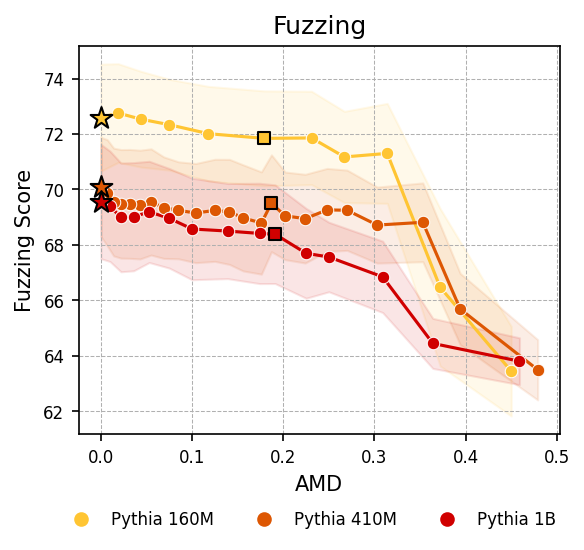

In [147]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3.5), dpi=150, layout="tight")

plot_vs_amd(fuzz_df_amd, ax)

ax.set_ylabel("Fuzzing Score")
ax.set_title("Fuzzing")
ax.grid(linestyle="--", linewidth=0.5)

# Create a single unique legend without a frame
handles = [
    plt.Line2D([0], [0], marker="o", color=palette[0], linestyle="", label="Pythia 160M"),
    plt.Line2D([0], [0], marker="o", color=palette[2], linestyle="", label="Pythia 410M"),
    plt.Line2D([0], [0], marker="o", color=palette[3], linestyle="", label="Pythia 1B"),
]
# bbox
fig.legend(
    handles=handles,
    loc="lower center",
    ncol=3,
    fontsize=8,
    frameon=False,
    bbox_to_anchor=(0.53, -0.05),
)

plt.savefig("imgs/fuzzing.pdf", bbox_inches="tight", dpi=300)
plt.show()

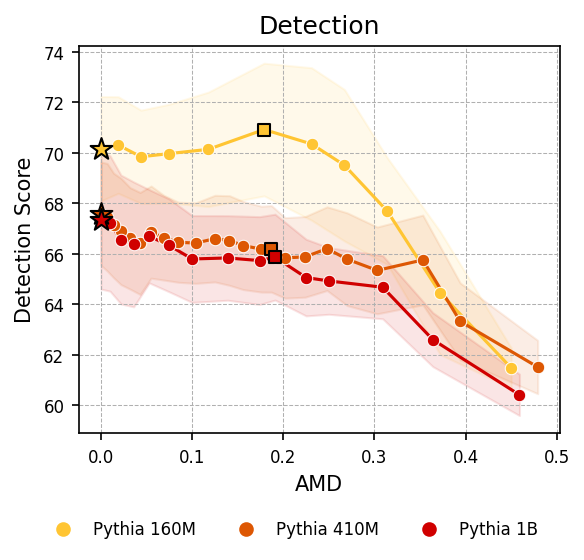

In [148]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3.5), dpi=150, layout="tight")

plot_vs_amd(detect_df_amd, ax)

ax.set_ylabel("Detection Score")
ax.set_title("Detection")
ax.grid(linestyle="--", linewidth=0.5)

# Create a single unique legend without a frame
handles = [
    plt.Line2D([0], [0], marker="o", color=palette[0], linestyle="", label="Pythia 160M"),
    plt.Line2D([0], [0], marker="o", color=palette[2], linestyle="", label="Pythia 410M"),
    plt.Line2D([0], [0], marker="o", color=palette[3], linestyle="", label="Pythia 1B"),
]
# bbox
fig.legend(
    handles=handles,
    loc="lower center",
    ncol=3,
    fontsize=8,
    frameon=False,
    bbox_to_anchor=(0.50, -0.07),
)

plt.savefig("imgs/detection.pdf", bbox_inches="tight", dpi=300)
plt.show()